<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Modelo Base</font></b></strong>

<strong><b><font size="5">Modelo de Previsão de Capacidade - Método Naive</font></b></strong>

In [1]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime
#from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy      1.16.6
pandas     1.0.5
sklearn    0.23.1
matplotlib 3.3.0
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [18]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [19]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-01,1980
2010-01-02,1931
2010-01-03,2041
2010-01-04,3711
2010-01-05,3642


In [20]:
dataframe.dtypes

QT_INTER    int64
dtype: object

In [21]:
dataframe.shape

(1096, 1)

In [22]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [23]:
# Random seed 
np.random.seed(7)

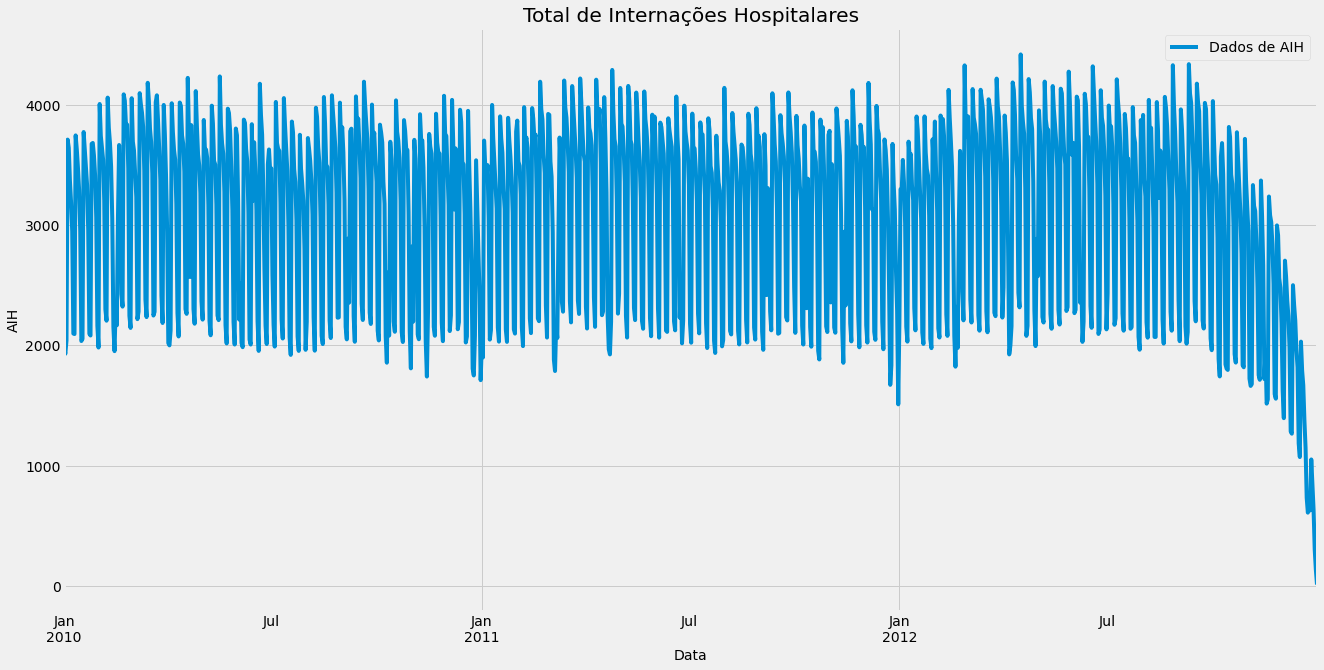

In [24]:
# Plot
target.plot(title = 'Total de Internações Hospitalares', fontsize = 14, label = 'Dados de AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [25]:
# Os dados de treino serão divididos em dados de treino e teste.
# Observe que os registros são separados em ordem cronológica.
treino = dataframe.iloc[0:822]
teste = dataframe.iloc[822:]
print(len(treino), len(teste))

822 274


## Forecasting - Modelagem Preditiva Para Séries Temporais

Criaremos vários modelos para este problema que temos em mãos, aumentando o grau de complexidade a cada versão.

Mas toda caminhada deve começar com o primeiro passo. Vamos começar com o modelo preditivo mais simples que podemos criar.

### Método Naive

Técnica de estimativa na qual os dados reais do último período são usados como previsão desse período, sem ajustá-los ou tentar estabelecer fatores causais. É usado apenas para comparação com as previsões geradas pelas melhores técnicas (sofisticadas).

Naive = ingênuo

Não há técnica avançada aqui e apenas usamos como ponto de partida. Qualquer modelo mais avançado deve apresentar resultados superiores ao Método Naive.

In [26]:
# Criamos um array com os valores da variável target em treino
target = np.asarray(treino.QT_INTER)
target

array([1980, 1931, 2041, 3711, 3642, 3369, 3190, 2948, 2099, 2095, 3746,
       3631, 3480, 3298, 2953, 2037, 2055, 3774, 3624, 3469, 3333, 2954,
       2097, 2083, 3676, 3683, 3580, 3414, 3066, 2163, 1983, 4007, 3742,
       3641, 3545, 3204, 2300, 2206, 4060, 3809, 3684, 3487, 3056, 2153,
       1953, 2329, 2168, 3070, 3666, 3346, 2427, 2323, 4087, 4033, 3828,
       3836, 3472, 2247, 2146, 4055, 3694, 3621, 3429, 3235, 2219, 2282,
       4097, 4006, 3934, 3817, 3450, 2382, 2236, 4183, 4034, 3799, 3691,
       3431, 2249, 2280, 4021, 4079, 3872, 3641, 3376, 2413, 2187, 3999,
       3754, 3411, 2947, 2020, 2001, 2125, 4013, 3774, 3625, 3544, 3174,
       2269, 2075, 4019, 3991, 3746, 3677, 3445, 2302, 2263, 4224, 3782,
       2569, 3832, 3407, 2303, 2181, 4114, 3820, 3588, 3498, 3268, 2367,
       2215, 3874, 3628, 3628, 3557, 3168, 2205, 2085, 3993, 3844, 3533,
       3504, 3172, 2249, 2211, 4236, 3833, 3680, 3595, 3276, 2169, 2017,
       3968, 3932, 3788, 3488, 3124, 2196, 2008, 38

In [27]:
# Cria uma cópia dos dados de validação
predict = teste.copy()
predict.head()

,QT_INTER
Data,
2012-04-02,3911
2012-04-03,3769
2012-04-04,3537
2012-04-05,2818
2012-04-06,1926


In [28]:
# Previsão

# Veja como o método é mesmo Naive
# Os dados reais (de treino) são usados como previsão para os dados de validação, 
# sem ajustá-los ou tentar estabelecer fatores causais.

# Sim, isso é o Método Naive!
predict['previsao_naive'] = target[len(target) - 1] 

In [29]:
# Colocamos lado a lado, valor real e valor "previsto"
predict[['QT_INTER', 'previsao_naive']].head()

,QT_INTER,previsao_naive
Data,,
2012-04-02,3911,2482
2012-04-03,3769,2482
2012-04-04,3537,2482
2012-04-05,2818,2482
2012-04-06,1926,2482


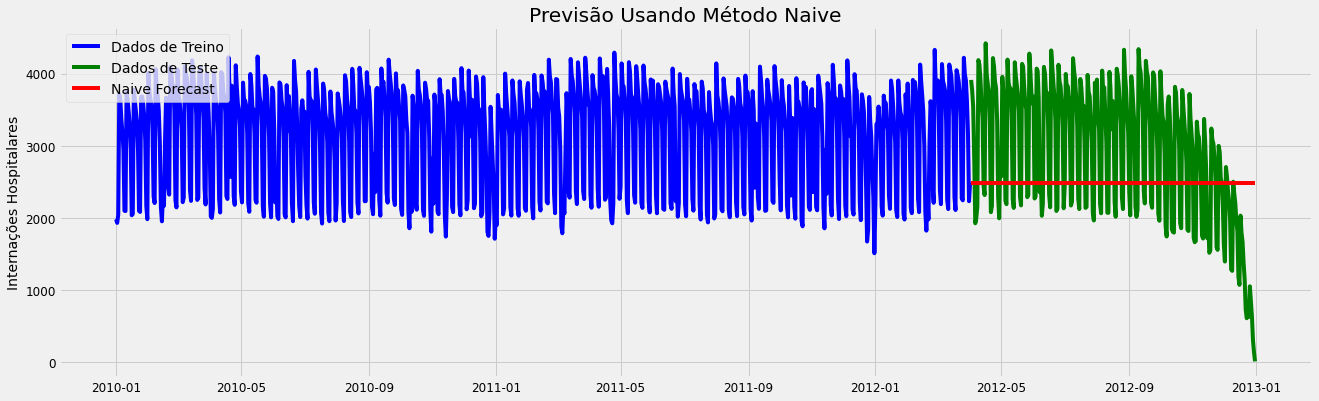

In [30]:
# Plot
plt.figure(figsize = (20, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(treino.index, treino['QT_INTER'], label = 'Dados de Treino', color = 'blue') 
plt.plot(teste.index, teste['QT_INTER'], label = 'Dados de Teste', color = 'green') 
plt.plot(predict.index, predict['previsao_naive'], label = 'Naive Forecast', color = 'red') 
plt.ylabel('Internações Hospitalares')
plt.legend(loc = 'upper left') 
plt.show()

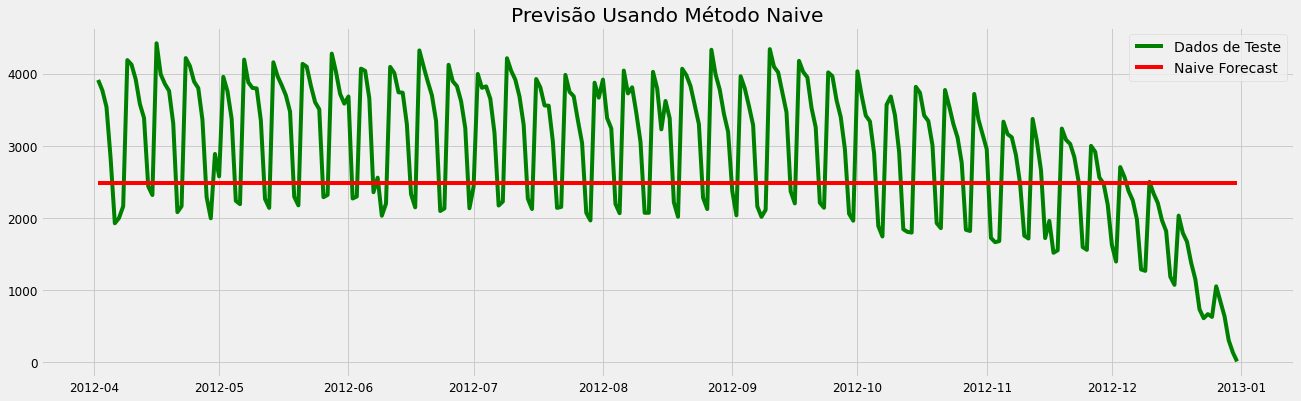

In [32]:
# Plot
plt.figure(figsize = (20, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(teste.index, teste['QT_INTER'], label = 'Dados de Teste', color = 'green') 
plt.plot(predict.index, predict['previsao_naive'], label = 'Naive Forecast', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

Pronto! Temos a previsão da nossa série! Você apresentaria esse modelo ao investidor disposto a investir no seu negócio? Espero que não! 

Então vamos trabalhar para criar um modelo robusto nas próximas aulas. Mas antes, vamos calcular a taxa de erro do modelo. 

In [18]:
# Define valor real e valor previsto
y_true = predict.Arrecadacao
y_pred = predict.previsao_naive

In [19]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse) 

805471.0878885308


Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim